In [92]:
import pandas as pd
pd.options.display.max_columns=200
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
import warnings 
warnings.filterwarnings('ignore')
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error,\
      mean_squared_log_error, mean_absolute_error, make_scorer, r2_score
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.compose import TransformedTargetRegressor
from sklearn.svm import SVR
from scipy.stats import skew
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor

In [93]:
data = pd.read_csv('data.csv')

In [94]:
data.set_index('OSEBuildingID', inplace = True)

In [95]:
data =data[~data.isin([np.nan, np.inf, -np.inf]).any(1)]

In [197]:
cols = ['Age','PropertyGFATotal',
       'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)',
       'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)',
       'LargestPropertyUseTypeGFA','ENERGYSTARScore', 'TotalGHGEmissions']

Age
0.29753360879193896


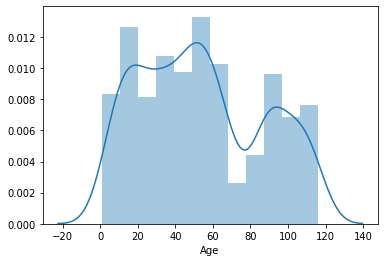

PropertyGFATotal
19.037917545145827


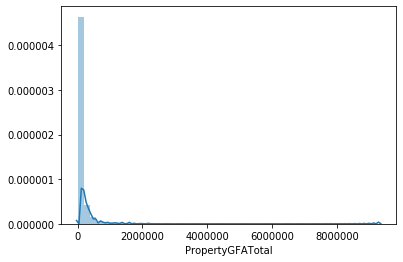

SiteEUI(kBtu/sf)
3.767000453173848


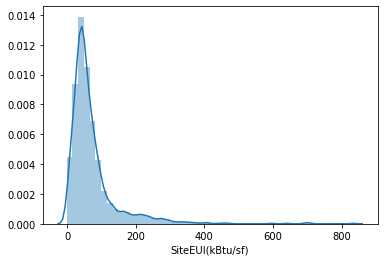

SiteEUIWN(kBtu/sf)
3.6664593768907086


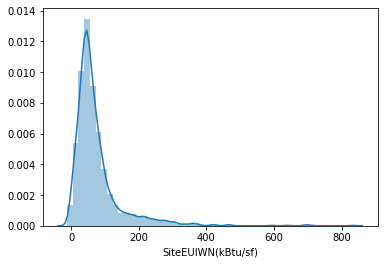

SourceEUI(kBtu/sf)
5.02139873400849


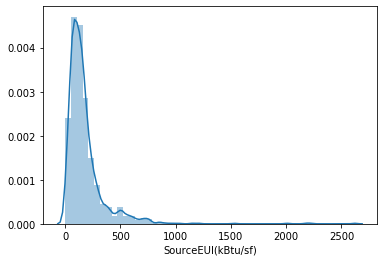

SourceEUIWN(kBtu/sf)
4.998804175082916


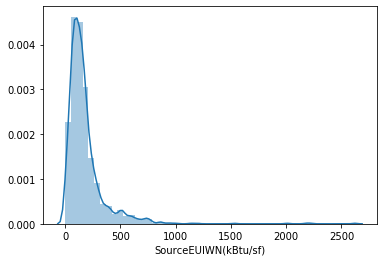

SiteEnergyUse(kBtu)
17.973308078803022


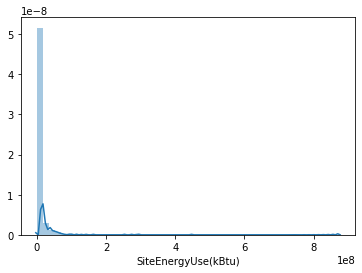

SiteEnergyUseWN(kBtu)
11.273463145790341


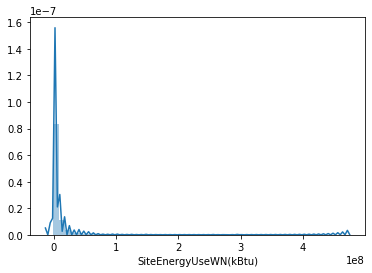

LargestPropertyUseTypeGFA
23.175161728669494


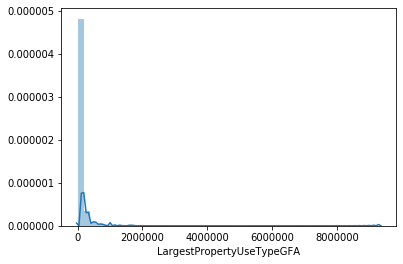

ENERGYSTARScore
0.07727154779048637


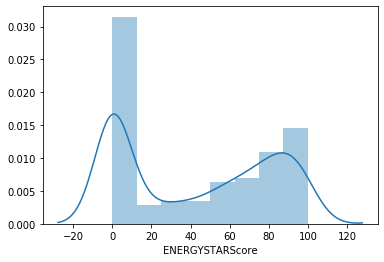

TotalGHGEmissions
14.130616835139792


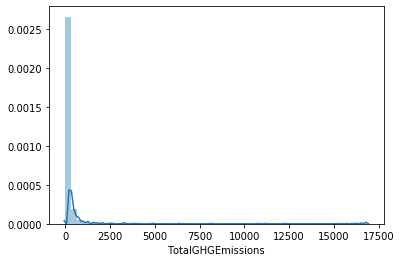

In [198]:
for col in cols:
      print(col)
      print(skew(data[col]))

      plt.figure()
      sns.distplot(data[col])
      plt.show()

In [199]:
cols = ['Age','PropertyGFATotal','PropertyGFAParking(%)',
        'PropertyGFABuilding(s)(%)','PropertyGFATotal',
       'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)',
       'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)',
        'LargestPropertyUseTypeGFA','ENERGYSTARScore', 'TotalGHGEmissions']

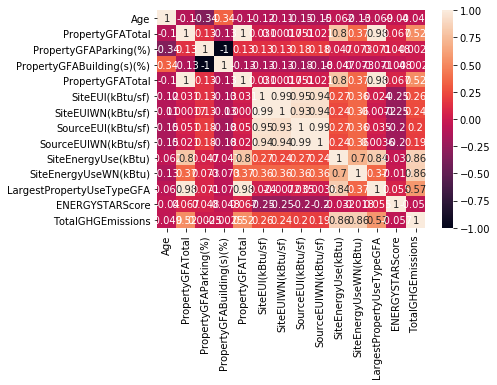

In [200]:
sns.heatmap(data[cols].corr(), annot = True)

In [220]:
X = data[['Age','NumberofBuildings','NumberofFloors','PropertyGFATotal','PropertyGFAParking(%)',
        'PropertyGFABuilding(s)(%)','LargestPropertyUseTypeGFA','ENERGYSTARScore','EnergyStarNaN',
        'PrimaryPropertyType_Distribution Center', 'PrimaryPropertyType_Hotel',
       'PrimaryPropertyType_K-12 School', 
       'PrimaryPropertyType_Large Office',
       'PrimaryPropertyType_Medical Office',
       'PrimaryPropertyType_Mixed Use Property',
       'PrimaryPropertyType_Other',
       'PrimaryPropertyType_Retail Store',
       'PrimaryPropertyType_Self-Storage Facility',
       'PrimaryPropertyType_Small- and Mid-Sized Office',
       'PrimaryPropertyType_Supermarket / Grocery Store',
       'PrimaryPropertyType_University', 'PrimaryPropertyType_Warehouse',
       'PrimaryPropertyType_Worship Facility','CouncilDistrictCode_1',
       'CouncilDistrictCode_2', 'CouncilDistrictCode_3',
       'CouncilDistrictCode_4', 'CouncilDistrictCode_5',
       'CouncilDistrictCode_6', 'CouncilDistrictCode_7']]


y = data['TotalGHGEmissions']

In [221]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [222]:
colsk = ['Age','PropertyGFATotal', 'LargestPropertyUseTypeGFA','ENERGYSTARScore']
X_train_tt = X_train.copy()
X_test_tt = X_test.copy()
X_train_tt[colsk] = np.log1p(X_train_tt[colsk])
X_test_tt[colsk] = np.log1p(X_test_tt[colsk])

In [223]:
std_scale = StandardScaler()
std_scale.fit(X_train)
X_train = std_scale.transform(X_train)
X_test = std_scale.transform(X_test)
X_train_tt = std_scale.transform(X_train_tt)
X_test_tt = std_scale.transform(X_test_tt)
X_train = pd.DataFrame(X_train, columns = X.columns)
X_test = pd.DataFrame(X_test, columns = X.columns)
X_train_tt = pd.DataFrame(X_train_tt, columns = X.columns)
X_test_tt = pd.DataFrame(X_test_tt, columns = X.columns)

In [225]:
dr = DummyRegressor(strategy="mean")
dr.fit(X_train, y_train)
baseline_error = mean_squared_error(y_test, dr.predict(y_test), squared=False)
baseline_error

770.5687305972889

In [226]:
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_error = mean_squared_error(y_test, lr.predict(X_test), squared=False)
lr_error

614.7720113903748

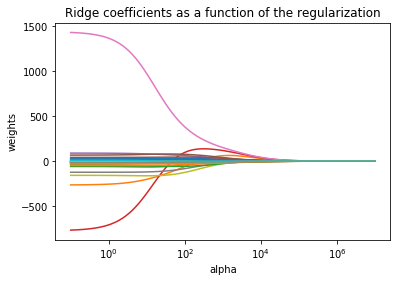

In [227]:
n_alphas = 100
alphas = np.logspace(-1, 7, n_alphas)

ridge = Ridge()

coefs = []
errors = []
for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(X_train, y_train)
    coefs.append(ridge.coef_)
    errors.append([baseline_error, mean_squared_error(y_test, ridge.predict(X_test), squared=False)])

ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

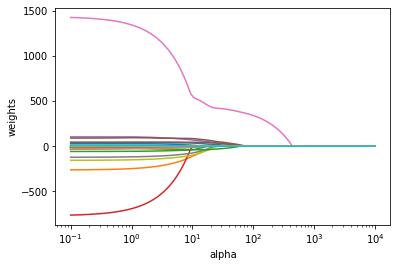

In [228]:
n_alphas = 100
alphas = np.logspace(-1, 4, n_alphas)
lasso = Lasso(fit_intercept=False)

coefs = []
errors = []
for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)
    errors.append([baseline_error, np.mean((lasso.predict(X_test) - y_test) ** 2)])


ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.axis('tight')
plt.show()

In [229]:
def resultize(grid):

    res = pd.DataFrame(grid.cv_results_)
    res = res[['params', 'mean_test_RMSE', 'rank_test_RMSE', 'mean_test_MSE', 'rank_test_MSE', 'mean_test_MAE', 'rank_test_MAE', 'mean_test_R2', 'rank_test_R2']]
    res['mean_test_MSE'] = (-res[f'mean_test_MSE'])
    res['mean_test_RMSE'] = (-res[f'mean_test_RMSE'])
    res['mean_test_MAE'] = (-res[f'mean_test_MAE'])
    res.sort_values(by='rank_test_RMSE', inplace=True)
    return res

In [230]:
s = {'MSE': 'neg_mean_squared_error', 
      'RMSE': 'neg_root_mean_squared_error',
      'MAE': 'neg_mean_absolute_error',
      'R2': 'r2'}
score = 'RMSE'

In [231]:
params = {'alpha': np.logspace(0, 7, 20)}
grid_ridge = GridSearchCV(Ridge(), params, cv = 10, 
                  scoring = s, refit = score, n_jobs=-1)
grid_ridge.fit(X_train, y_train)
grid_ridge_best_params = grid_ridge.best_params_
resultize(grid_ridge).head()

,params,mean_test_RMSE,rank_test_RMSE,mean_test_MSE,rank_test_MSE,mean_test_MAE,rank_test_MAE,mean_test_R2,rank_test_R2
8,{'alpha': 885.8667904100823},476.639195,1,391733.232026,1,158.033462,1,0.174566,2
7,{'alpha': 379.26901907322497},499.014277,2,399812.073361,2,166.462100,2,0.098645,4
9,{'alpha': 2069.138081114788},516.894437,3,430045.350869,3,167.498079,3,0.175937,1
10,{'alpha': 4832.930238571752},554.135987,4,478036.314766,4,181.645970,4,0.121211,3
6,{'alpha': 162.3776739188721},558.543953,5,487951.291381,5,183.185330,5,-0.068267,7


In [235]:
grid_ridge_best_params = {'alpha': 885.8667904100823}	

In [236]:
ridge = Ridge(**grid_ridge_best_params)
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)
ridge_error = mean_squared_error(y_test, y_pred, squared=False)
ridge_error

672.8791568764291

In [63]:
params = {"alpha": np.logspace(-1, 3, 30)}
grid_lasso = GridSearchCV(Lasso(), params, cv = 10, 
                  scoring = s, refit = score, n_jobs=-1)
grid_lasso.fit(X_train, y_train)
grid_lasso_best_params = grid_lasso.best_params_
resultize(grid_lasso).head()

,params,mean_test_RMSE,rank_test_RMSE,mean_test_MSE,rank_test_MSE,mean_test_MAE,rank_test_MAE,mean_test_R2,rank_test_R2
21,{'alpha': 78.80462815669912},482.426558,1,287018.667921,1,156.079568,2,0.314691,1
22,{'alpha': 108.2636733874054},483.821142,2,290925.425738,2,159.498764,3,0.300916,3
20,{'alpha': 57.361525104486816},492.310747,3,295571.337810,3,156.072793,1,0.308447,2
23,{'alpha': 148.73521072935117},507.120903,4,317067.628852,4,165.838400,5,0.273989,4
19,{'alpha': 41.753189365604},538.126128,5,375256.313755,5,161.744613,4,0.238725,5


In [64]:
grid_lasso_best_params = {'alpha': 529.8316906283708}

In [65]:
lasso = Lasso(**grid_lasso_best_params)
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)
lasso_error = mean_squared_error(y_test, y_pred, squared=False)
lasso_error

968.2106104387265

In [67]:
tt_ridge = TransformedTargetRegressor(regressor = Ridge(),
                               func = np.log1p,
                               inverse_func = np.expm1)
tt_ridge.fit(X_train_tt, y_train)
y_pred = tt_ridge.predict(X_test)
tt_ridge_error = mean_squared_error(y_test, y_pred, squared=False)
tt_ridge_error

984.3727462405766

In [68]:
params = {'regressor__alpha': np.logspace(0, 7, 100)}
grid_tt_ridge = GridSearchCV(tt_ridge, scoring=s, refit = score, param_grid=params, cv = 10)
grid_tt_ridge.fit(X_train, y_train)
grid_tt_ridge_best_params = grid_tt_ridge.best_params_
resultize(grid_tt_ridge).head()

,params,mean_test_RMSE,rank_test_RMSE,mean_test_MSE,rank_test_MSE,mean_test_MAE,rank_test_MAE,mean_test_R2,rank_test_R2
51,{'regressor__alpha': 4037.017258596554},567.511958,1,398873.246062,1,146.215892,1,0.052489,1
52,{'regressor__alpha': 4750.810162102794},573.197078,2,405335.331704,2,147.740556,2,0.043605,2
53,{'regressor__alpha': 5590.810182512223},594.247751,3,433864.998985,3,150.931698,3,0.015224,3
54,{'regressor__alpha': 6579.3322465756755},606.987103,4,454950.337828,4,152.851582,4,-0.006245,4
55,{'regressor__alpha': 7742.63682681127},614.372123,5,468317.285025,5,154.134686,5,-0.020559,5


In [69]:
grid_tt_ridge_best_params = {'alpha': 4037.017258596554}

In [70]:
tt_ridge = TransformedTargetRegressor(regressor = Ridge(**grid_tt_ridge_best_params),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
tt_ridge.fit(X_train, y_train)
y_pred = tt_ridge.predict(X_test)
tt_ridge_error = mean_squared_error(y_test, y_pred, squared=False)
tt_ridge_error

975.9617424881096

In [237]:
tt_lasso = TransformedTargetRegressor(regressor = Lasso(),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
tt_lasso.fit(X_train_tt, y_train)
y_pred = tt_lasso.predict(X_test_tt)
tt_lasso_error = mean_squared_error(y_test, y_pred, squared=False)
tt_lasso_error

782.3317135722698

In [239]:
tt_lasso = TransformedTargetRegressor(regressor = Lasso(),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
params = {'regressor__alpha': np.logspace(-1, 3, 30)}
grid_tt_lasso = GridSearchCV(tt_lasso, scoring=s, refit = score, param_grid=params, cv = 10)
grid_tt_lasso.fit(X_train_tt, y_train)
grid_tt_lasso_best_params = grid_tt_lasso.best_params_
resultize(grid_tt_lasso).head()

,params,mean_test_RMSE,rank_test_RMSE,mean_test_MSE,rank_test_MSE,mean_test_MAE,rank_test_MAE,mean_test_R2,rank_test_R2
1,{'regressor__alpha': 0.1373823795883263},615.054720,1,575334.088455,2,154.215587,2,0.027574,1
2,{'regressor__alpha': 0.18873918221350972},616.212353,2,575120.913624,1,155.208703,3,0.013224,3
0,{'regressor__alpha': 0.1},616.501047,3,578332.669582,4,153.792395,1,0.026572,2
3,{'regressor__alpha': 0.2592943797404667},619.937909,4,577916.425811,3,157.671034,4,-0.013550,4
4,{'regressor__alpha': 0.3562247890262442},623.603543,5,580902.075530,5,161.424240,5,-0.040006,5


In [241]:
grid_tt_lasso_best_params = {'alpha': 529.8316906283708}
tt_lasso = TransformedTargetRegressor(regressor = Lasso(**grid_tt_lasso_best_params),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
tt_lasso.fit(X_train_tt, y_train)
y_pred = tt_lasso.predict(X_test_tt)
tt_lasso_error = mean_squared_error(y_test, y_pred, squared=False)
tt_lasso_error

782.3317135722698

In [71]:
svr = SVR()
svr.fit(X_train, y_train)
y_pred = svr.predict(X_test)
svr_error = mean_squared_error(y_test, y_pred, squared=False)
svr_error

977.6534948431871

In [243]:
params = {'kernel': ['sigmoid','rbf','poly'],
         'C': [0.1,1,100,1000],
         'degree': [1,2,3,4,5,6]}
grid_svr = GridSearchCV(SVR(), params, cv=10, scoring = s,
                        refit = score,  n_jobs=-1)
grid_svr.fit(X_train, y_train)
best_params_svr = grid_svr.best_params_
resultize(grid_svr).head()

,params,mean_test_RMSE,rank_test_RMSE,mean_test_MSE,rank_test_MSE,mean_test_MAE,rank_test_MAE,mean_test_R2,rank_test_R2
56,"{'C': 1000, 'degree': 1, 'kernel': 'poly'}",475.803318,1,395389.542506,1,125.826171,1,0.323142,1
38,"{'C': 100, 'degree': 1, 'kernel': 'poly'}",490.866822,2,411039.931766,2,126.764483,2,0.310659,2
64,"{'C': 1000, 'degree': 4, 'kernel': 'rbf'}",532.779024,3,470455.441298,3,130.545493,3,0.296809,3
67,"{'C': 1000, 'degree': 5, 'kernel': 'rbf'}",532.779024,3,470455.441298,3,130.545493,3,0.296809,3
61,"{'C': 1000, 'degree': 3, 'kernel': 'rbf'}",532.779024,3,470455.441298,3,130.545493,3,0.296809,3


In [244]:
best_params_svr = {'C': 1000, 'degree': 4, 'kernel': 'rbf'}

In [245]:
svr = SVR(**best_params_svr)
svr.fit(X_train, y_train)
y_pred = svr.predict(X_test)
svr_error = mean_squared_error(y_test, y_pred, squared=False)
svr_error

619.1956015136988

In [246]:
tt_svr = TransformedTargetRegressor(regressor = SVR(**best_params_svr),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
tt_svr.fit(X_train_tt, y_train)
y_pred = tt_svr.predict(X_test_tt)
mean_squared_error(y_test, y_pred, squared=False)

2476.3095558446526

In [248]:
"""tt_svr = TransformedTargetRegressor(regressor = SVR(),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
params = {'regressor__C': [0.1,1,100,1000],
            'regressor__degree': [1,2,3,4,5,6],
            'regressor__kernel': ['sigmoid','rbf','poly']}
grid_tt_svr = GridSearchCV(tt_svr, params, cv = 10, scoring = s, refit = score, n_jobs=-1)
grid_tt_svr.fit(X_train_tt, y_train)
best_params_svr_tt = grid_tt_svr.best_params_
resultize(grid_tt_svr).head()"""

"tt_svr = TransformedTargetRegressor(regressor = SVR(),\n                                    func = np.log1p,\n                                    inverse_func = np.expm1)\nparams = {'regressor__C': [0.1,1,100,1000],\n            'regressor__degree': [1,2,3,4,5,6],\n            'regressor__kernel': ['sigmoid','rbf','poly']}\ngrid_tt_svr = GridSearchCV(tt_svr, params, cv = 10, scoring = s, refit = score, n_jobs=-1)\ngrid_tt_svr.fit(X_train_tt, y_train)\nbest_params_svr_tt = grid_tt_svr.best_params_\nresultize(grid_tt_svr).head()"

In [180]:
'''tt = TransformedTargetRegressor(regressor = SVR(**best_params_svr_tt),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
tt.fit(X_train, y_train)
y_pred = tt.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)'''

'tt = TransformedTargetRegressor(regressor = SVR(**best_params_svr_tt),\n                                    func = np.log1p,\n                                    inverse_func = np.expm1)\ntt.fit(X_train, y_train)\ny_pred = tt.predict(X_test)\nmean_squared_error(y_test, y_pred, squared=False)'

In [249]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

454.68334819682633

In [251]:
"""params = {'n_estimators': [100, 200, 300, 400, 500],
            'max_depth': [1,2,3,4,5,6,7,8,9,10],
            'min_samples_split': [2,3,4,5,6,7,8,9,10],
}
grid_rf = GridSearchCV(RandomForestRegressor(), params, cv=10, scoring = s, refit = score, n_jobs=-1)
grid_rf.fit(X_train, y_train)
best_params_rf = grid_rf.best_params_
resultize(grid_rf).head()"""

,params,mean_test_RMSE,rank_test_RMSE,mean_test_MSE,rank_test_MSE,mean_test_MAE,rank_test_MAE,mean_test_R2,rank_test_R2
320,"{'max_depth': 8, 'min_samples_split': 3, 'n_es...",529.910315,1,420737.191200,2,147.392230,1,-0.356714,158
200,"{'max_depth': 5, 'min_samples_split': 6, 'n_es...",533.144175,2,428850.686760,9,151.897275,116,-0.150904,1
291,"{'max_depth': 7, 'min_samples_split': 6, 'n_es...",534.610703,3,429191.639289,12,149.959846,29,-0.395760,244
290,"{'max_depth': 7, 'min_samples_split': 6, 'n_es...",535.760434,4,426353.186951,6,150.758072,55,-0.348020,143
249,"{'max_depth': 6, 'min_samples_split': 6, 'n_es...",535.821449,5,433123.124656,37,151.641189,95,-0.236724,10


In [253]:
best_params_rf = {'max_depth': 8, 'min_samples_split': 3, 'n_estimators': 100}

In [254]:
rf = RandomForestRegressor(**best_params_rf)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
rf_error = mean_squared_error(y_test, y_pred, squared=False)
rf_error

444.51705585985565

In [255]:
tt_rf = TransformedTargetRegressor(regressor = RandomForestRegressor(**best_params_rf),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
tt_rf.fit(X_train_tt, y_train)
y_pred = tt_rf.predict(X_test_tt)
tt_rf_error = mean_squared_error(y_test, y_pred, squared=False)
tt_rf_error

530.8644833894044

In [256]:
"""tt_rf = TransformedTargetRegressor(regressor = RandomForestRegressor(),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
params = {'regressor__n_estimators': [100, 200, 300, 400, 500],
            'regressor__max_depth': [1,2,3,4,5,6,7,8,9,10],
            'regressor__min_samples_split': [2,3,4,5,6,7,8,9,10]}
grid_tt_rf = GridSearchCV(tt_rf, params, cv = 10, scoring = s, refit = score, n_jobs=-1)
grid_tt_rf.fit(X_train_tt, y_train)
best_params_tt_rf = grid_tt_rf.best_params_
resultize(grid_tt_rf).head()"""

,params,mean_test_RMSE,rank_test_RMSE,mean_test_MSE,rank_test_MSE,mean_test_MAE,rank_test_MAE,mean_test_R2,rank_test_R2
376,"{'regressor__max_depth': 9, 'regressor__min_sa...",481.528926,1,390744.404824,3,122.655244,55,0.388890,5
335,"{'regressor__max_depth': 8, 'regressor__min_sa...",481.551179,2,389406.439884,2,121.994460,15,0.384872,17
425,"{'regressor__max_depth': 10, 'regressor__min_s...",481.846210,3,389297.875984,1,121.622501,5,0.376000,56
410,"{'regressor__max_depth': 10, 'regressor__min_s...",482.482389,4,392430.289726,6,121.755716,7,0.379875,36
371,"{'regressor__max_depth': 9, 'regressor__min_sa...",483.666382,5,393356.739322,11,122.271410,23,0.387002,10


In [258]:
best_params_tt_rf = {'regressor__max_depth': 9, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 200}

In [260]:
best_params_tt_rf = {'max_depth': 10,
 'min_samples_split': 4,
 'n_estimators': 200}
rf_tt = TransformedTargetRegressor(
      regressor = RandomForestRegressor(**best_params_tt_rf),
      func = np.log1p,
      inverse_func = np.expm1)
rf_tt.fit(X_train_tt, y_train)
y_pred = rf_tt.predict(X_test_tt)
rf_tt_error = mean_squared_error(y_test, y_pred, squared=False)
rf_tt_error

539.2334494350862

In [261]:
gb = GradientBoostingRegressor()
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
gb_error = mean_squared_error(y_test, y_pred, squared=False)
gb_error

383.6988114962267

In [262]:
"""params = {'loss': ['ls', 'lad', 'huber', 'quantile'],
            'learning_rate': [0.1, 0.05, 0.02, 0.01],
            'max_depth': [4, 6],
            'min_samples_leaf': [3, 5, 9, 17],
}
grid_gb = GridSearchCV(GradientBoostingRegressor(), params, cv=10, scoring = s, refit = score, n_jobs=-1)
grid_gb.fit(X_train, y_train)
best_params_gb = grid_gb.best_params_
resultize(grid_gb).head()"""

,params,mean_test_RMSE,rank_test_RMSE,mean_test_MSE,rank_test_MSE,mean_test_MAE,rank_test_MAE,mean_test_R2,rank_test_R2
52,"{'learning_rate': 0.05, 'loss': 'huber', 'max_...",449.740098,1,344954.129256,4,121.999409,3,0.450709,1
17,"{'learning_rate': 0.1, 'loss': 'huber', 'max_d...",461.004085,2,350626.396414,7,122.544362,6,0.236917,52
53,"{'learning_rate': 0.05, 'loss': 'huber', 'max_...",464.402632,3,359898.665163,10,124.078811,15,0.256786,46
21,"{'learning_rate': 0.1, 'loss': 'huber', 'max_d...",466.180106,4,357491.638204,9,125.670556,27,0.332176,21
16,"{'learning_rate': 0.1, 'loss': 'huber', 'max_d...",466.757688,5,354086.116229,8,124.658556,18,0.140557,70


In [264]:
best_params_gb = {'learning_rate': 0.05, 'loss': 'huber', 'max_depth': 6, 'min_samples_leaf': 3}

In [265]:
gb = GradientBoostingRegressor(**best_params_gb)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
gb_error = mean_squared_error(y_test, y_pred, squared=False)
gb_error

504.5652758187729

In [266]:
"""tt_gb = TransformedTargetRegressor(regressor = GradientBoostingRegressor(),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
params = {'regressor__loss': ['ls', 'lad', 'huber', 'quantile'],
            'regressor__learning_rate': [0.1, 0.05, 0.02, 0.01],
            'regressor__max_depth': [4, 6],
            'regressor__min_samples_leaf': [3, 5, 9, 17]}
grid_tt_gb = GridSearchCV(tt_gb, params, cv = 10, scoring = s, refit = score, n_jobs=-1)
grid_tt_gb.fit(X_train_tt, y_train)
best_params_gb_tt = grid_tt_gb.best_params_
resultize(grid_tt_gb).head()"""

,params,mean_test_RMSE,rank_test_RMSE,mean_test_MSE,rank_test_MSE,mean_test_MAE,rank_test_MAE,mean_test_R2,rank_test_R2
17,"{'regressor__learning_rate': 0.1, 'regressor__...",421.886205,1,304688.427461,1,115.916318,2,0.439157,5
1,"{'regressor__learning_rate': 0.1, 'regressor__...",428.722836,2,309107.144581,2,118.650659,11,0.442064,4
21,"{'regressor__learning_rate': 0.1, 'regressor__...",437.408094,3,329913.033038,3,114.401028,1,0.425972,7
5,"{'regressor__learning_rate': 0.1, 'regressor__...",437.874665,4,336421.114153,8,117.820729,7,0.460112,1
18,"{'regressor__learning_rate': 0.1, 'regressor__...",439.997203,5,335662.670607,7,117.349905,6,0.452839,2


In [286]:
best_params_gb_tt = {'learning_rate': 0.1,
      'loss': 'huber',
      'max_depth': 4,
      'min_samples_leaf': 5
      }
gb_tt = TransformedTargetRegressor(regressor=GradientBoostingRegressor(**best_params_gb_tt),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
gb_tt.fit(X_train_tt, y_train)
y_pred = gb_tt.predict(X_test_tt)
tt_gb_error = mean_squared_error(y_test, y_pred, squared=False)
tt_gb_error

324.9467284485059

In [269]:
ad =  AdaBoostRegressor()
ad.fit(X_train, y_train)
y_pred = ad.predict(X_test)
ad_error = mean_squared_error(y_test, y_pred, squared=False)
ad_error

700.3686721177091

In [270]:
params = {'n_estimators': [100, 200, 300, 400, 500],
            'learning_rate': [0.1, 0.05, 0.02, 0.01],
            'loss': ['linear', 'square', 'exponential'],
}
grid_ad = GridSearchCV(AdaBoostRegressor(), params, cv=10, scoring = s, refit = score, n_jobs=-1)
grid_ad.fit(X_train, y_train)
best_params_ad = grid_ad.best_params_
resultize(grid_ad).head()

,params,mean_test_RMSE,rank_test_RMSE,mean_test_MSE,rank_test_MSE,mean_test_MAE,rank_test_MAE,mean_test_R2,rank_test_R2
10,"{'learning_rate': 0.1, 'loss': 'exponential', ...",554.823787,1,451625.931063,1,185.036391,16,-0.347784,1
55,"{'learning_rate': 0.01, 'loss': 'exponential',...",610.749453,2,566156.557296,3,171.151363,1,-0.381113,5
6,"{'learning_rate': 0.1, 'loss': 'square', 'n_es...",611.822033,3,551453.642088,2,192.546638,27,-0.664053,31
57,"{'learning_rate': 0.01, 'loss': 'exponential',...",619.845889,4,577564.154557,4,181.038870,8,-0.528176,17
52,"{'learning_rate': 0.01, 'loss': 'square', 'n_e...",624.453974,5,610371.333880,8,180.211631,7,-0.359419,2


In [272]:
best_params_ad = {'learning_rate': 0.1, 'loss': 'exponential', 'n_estimators': 100}

In [273]:
ad = AdaBoostRegressor(**best_params_ad)
ad.fit(X_train, y_train)
y_pred = ad.predict(X_test)
ad_error = mean_squared_error(y_test, y_pred, squared=False)
ad_error

485.10391967850984

In [274]:
tt_ad = TransformedTargetRegressor(regressor = AdaBoostRegressor(),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
params = {'regressor__n_estimators': [100, 200, 300, 400, 500],
            'regressor__learning_rate': [0.1, 0.05, 0.02, 0.01],
            'regressor__loss': ['linear', 'square', 'exponential'],
}
grid_tt_ad = GridSearchCV(tt_ad, params, cv = 10, scoring = s, refit = score, n_jobs=-1)
grid_tt_ad.fit(X_train_tt, y_train)
best_params_ad_tt = grid_tt_ad.best_params_
resultize(grid_tt_ad).head()

,params,mean_test_RMSE,rank_test_RMSE,mean_test_MSE,rank_test_MSE,mean_test_MAE,rank_test_MAE,mean_test_R2,rank_test_R2
27,"{'regressor__learning_rate': 0.05, 'regressor_...",526.136914,1,447637.377913,1,135.039267,7,0.275413,1
16,"{'regressor__learning_rate': 0.05, 'regressor_...",528.006986,2,451310.478701,4,135.466992,25,0.270924,4
20,"{'regressor__learning_rate': 0.05, 'regressor_...",528.021156,3,449213.229266,2,135.243045,17,0.263606,10
10,"{'regressor__learning_rate': 0.1, 'regressor__...",528.166764,4,450216.346286,3,134.926880,5,0.271974,3
59,"{'regressor__learning_rate': 0.01, 'regressor_...",528.289441,5,451455.101330,5,134.275375,1,0.258414,19


In [275]:
best_params_ad_tt

{'regressor__learning_rate': 0.05,
 'regressor__loss': 'exponential',
 'regressor__n_estimators': 300}

In [276]:
best_params_ad_tt = {'learning_rate': 0.05,
      'loss': 'exponential',
      'n_estimators': 300
      }
tt_ad = TransformedTargetRegressor(regressor=AdaBoostRegressor(**best_params_ad_tt),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
tt_ad.fit(X_train_tt, y_train)
y_pred = tt_ad.predict(X_test_tt)
tt_ad_error = mean_squared_error(y_test, y_pred, squared=False)
tt_ad_error

636.1528988460393

In [277]:
from sklearn.neural_network import MLPRegressor
mlp = MLPRegressor()
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)
mlp_error = mean_squared_error(y_test, y_pred, squared=False)
mlp_error

677.7869136297613

In [278]:
params = {'hidden_layer_sizes': [(100,),(200,),(300,),(400,),(500,)],
            'activation': ['identity', 'logistic', 'tanh', 'relu'],
            'solver': ['lbfgs', 'adam'],
}
grid_mlp = GridSearchCV(MLPRegressor(), params, cv=10, scoring = s, refit = score, n_jobs=-1)
grid_mlp.fit(X_train, y_train)
best_params_mlp = grid_mlp.best_params_
resultize(grid_mlp).head()

,params,mean_test_RMSE,rank_test_RMSE,mean_test_MSE,rank_test_MSE,mean_test_MAE,rank_test_MAE,mean_test_R2,rank_test_R2
31,"{'activation': 'relu', 'hidden_layer_sizes': (...",493.251256,1,409648.753872,3,166.259404,11,0.015288,11
1,"{'activation': 'identity', 'hidden_layer_sizes...",495.007461,2,407859.764061,1,186.509547,20,-0.025210,14
33,"{'activation': 'relu', 'hidden_layer_sizes': (...",504.292852,3,408287.625443,2,169.085507,13,0.003354,12
3,"{'activation': 'identity', 'hidden_layer_sizes...",525.882569,4,424810.524701,4,195.538896,21,-0.108885,17
35,"{'activation': 'relu', 'hidden_layer_sizes': (...",529.914403,5,444077.626023,5,169.804163,14,-0.006272,13


In [280]:
best_params_mlp = {'activation': 'relu', 'hidden_layer_sizes': (100,), 'solver': 'adam'}

In [281]:
mlp = MLPRegressor(**best_params_mlp)
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)
mlp_error = mean_squared_error(y_test, y_pred, squared=False)
mlp_error

678.0021812804783

In [282]:
tt_mlp = TransformedTargetRegressor(regressor = MLPRegressor(),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
params = {'regressor__hidden_layer_sizes': [(100,),(200,),(300,),(400,),(500,)],
            'regressor__activation': ['identity', 'logistic', 'tanh', 'relu'],
            'regressor__solver': ['lbfgs', 'adam'],
}
grid_tt_mlp = GridSearchCV(tt_mlp, params, cv = 10, scoring = s, refit = score, n_jobs=-1)
grid_tt_mlp.fit(X_train_tt, y_train)
best_params_tt_mlp = grid_tt_mlp.best_params_
resultize(grid_tt_mlp).head()

,params,mean_test_RMSE,rank_test_RMSE,mean_test_MSE,rank_test_MSE,mean_test_MAE,rank_test_MAE,mean_test_R2,rank_test_R2
13,"{'regressor__activation': 'logistic', 'regress...",516.502351,1,455674.071701,1,138.150991,1,0.218266,1
21,"{'regressor__activation': 'tanh', 'regressor__...",562.453078,2,486564.243538,2,144.158383,3,0.160526,3
11,"{'regressor__activation': 'logistic', 'regress...",564.614710,3,502469.507331,3,142.640008,2,0.172083,2
25,"{'regressor__activation': 'tanh', 'regressor__...",585.801853,4,523267.412992,4,147.683756,5,0.060454,5
23,"{'regressor__activation': 'tanh', 'regressor__...",587.085263,5,525834.154298,5,147.177877,4,0.060704,4


In [283]:
best_params_tt_mlp

{'regressor__activation': 'logistic',
 'regressor__hidden_layer_sizes': (200,),
 'regressor__solver': 'adam'}

In [284]:
best_params_tt_mlp = {'activation': 'logistic',
      'hidden_layer_sizes': (200,),
      'solver': 'adam'
      }
tt_mlp = TransformedTargetRegressor(regressor=MLPRegressor(**best_params_tt_mlp),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
tt_mlp.fit(X_train_tt, y_train)
y_pred = tt_mlp.predict(X_test_tt)
tt_mlp_error = mean_squared_error(y_test, y_pred, squared=False)
tt_mlp_error

743.9003584446453

In [287]:
errors = {'Linear Regression': lr_error,
            'Ridge': ridge_error,
            'Lasso': lasso_error,
            'Ridge_tt': tt_ridge_error,
            'Lasso_tt': tt_lasso_error,
            'SVR': svr_error,
            'Random Forest': rf_error,
            'Random Forest_tt': tt_rf_error,
            'Gradient Boosting': gb_error,
            'Gradient Boosting_tt': tt_gb_error,
            'AdaBoost': ad_error,
            'AdaBoost_tt': tt_ad_error,
            'MLP': mlp_error,
            'MLP_tt': tt_mlp_error
}

In [291]:
min(errors, key=errors.get, default=None), min(errors.values())

('Gradient Boosting_tt', 324.9467284485059)

In [292]:
#Classement des erreurs
errors = pd.DataFrame(errors.items(), columns=['Model', 'RMSE'])
errors = errors.sort_values(by='RMSE', ascending=True)
errors

,Model,RMSE
9,Gradient Boosting_tt,324.946728
6,Random Forest,444.517056
10,AdaBoost,485.103920
8,Gradient Boosting,504.565276
7,Random Forest_tt,530.864483
0,Linear Regression,614.772011
5,SVR,619.195602
11,AdaBoost_tt,636.152899
1,Ridge,672.879157
12,MLP,678.002181


In [300]:
from xgboost import XGBRegressor

In [301]:
xgb = XGBRegressor()
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
xgb_error = mean_squared_error(y_test, y_pred, squared=False)
xgb_error

521.7359874509264

In [304]:
params = {'n_estimators': [100, 200, 300, 400, 500],
            'learning_rate': [0.1, 0.05, 0.02, 0.01],
            'max_depth': [3, 4, 5, 6, 7]
            }
grid_xgb = GridSearchCV(XGBRegressor(), params, cv=10, scoring = s, refit = score, n_jobs=-1)
grid_xgb.fit(X_train, y_train)
best_params_xgb = grid_xgb.best_params_
resultize(grid_xgb).head()

KeyboardInterrupt: 